## In questo file andiamo ad applicare algoritmi di clustering dopo aver eliminato eventuali duplicati ed aver ridotto le dimensioni del dataset con undersampling. Prima di applicare gli algoritmi di clustering, applichiamo la pca che ci permette di selezionare le feature più rilevanti

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from matplotlib.lines import Line2D
import os

In [2]:
nome_file='Thursday-15-02-2018_TrafficForML_CICFlowMeter'

with open('pickle/'+nome_file+'/scaled_document.pickle', 'rb') as handle:

    df = pickle.load(handle)

In [3]:
#eliminazione duplicati

df = df.drop_duplicates()

In [4]:
# Seleziona una frazione casuale delle righe in base a una colonna specifica
# Selezioniamo il 50% delle righe

colonna_interessata = 'Label'
frazione_da_selezionare = 0.5  # Ad esempio, seleziona il 50% delle righe


df = df.groupby(colonna_interessata).apply(lambda x: x.sample(frac=frazione_da_selezionare, random_state=42)).reset_index(drop=True)

In [5]:
for i in range(len(df)):
    if df.loc[i, 'Label'] != 0:
        df.loc[i, 'Label'] = 1

In [6]:
#contiamo il numero di feature per label

df_prova = df.groupby(['Label'])['Label'].count()

df_prova=df_prova.to_frame()
print(df_prova)
df_prova.set_index('Label')
df_prova=df_prova.rename(columns={'Label':'Count'})

        Label
Label        
0      371749
1       25657


In [7]:
#creiamo un array in cui andiamo a mettere le 5 feature più importanti per filtrare poi il dataframe

import csv

results = []
with open('top_feature/'+ nome_file +'/top5.csv', newline='') as inputfile:
    for row in csv.reader(inputfile):
        results.append(row[0])

results.pop(0)
print(results)

['Fwd Seg Size Min', 'Bwd IAT Mean', 'Init Fwd Win Byts', 'Bwd IAT Min', 'Init Bwd Win Byts']


In [8]:
#otteniamo il dataframe con solo le 5 feature più importanti

df_filtrato = pd.DataFrame()
for a in df.head(0):
    if a in results:
        df_filtrato[a] = df[a]

df_filtrato['Label'] = df['Label']
display(df_filtrato)

,Bwd IAT Mean,Bwd IAT Min,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Seg Size Min,Label
0,0.000000,0.000000,0.001953,0.000015,0.357143,0
1,0.061369,0.000097,0.125015,0.001831,0.357143,0
2,0.020622,0.000000,0.125015,0.002899,0.357143,0
3,0.000000,0.000000,0.002701,0.000015,0.357143,0
4,0.002658,0.001429,0.125015,0.959122,0.357143,0
...,...,...,...,...,...,...
397401,0.446719,0.258510,0.410217,0.000015,0.571429,1
397402,0.859588,0.859588,0.003235,0.003357,0.571429,1
397403,0.445516,0.258497,0.410217,0.000015,0.571429,1
397404,0.000000,0.000000,0.410217,0.000000,0.714286,1


In [9]:
dos = df_filtrato[df_filtrato.Label == 1]
benign = df_filtrato[df_filtrato.Label == 0]

print("Benign: ", len(benign), "dos: ", len(dos))

Benign:  371749 dos:  25657


In [10]:
#bilanciamento del dataset
balanced_d = pd.concat([dos, benign.sample(len(dos))])
bal_x = balanced_d.iloc[:,:-1]
bal_y = balanced_d.iloc[:,-1:]
balanced_d.shape

(51314, 6)

## Applicazione della PCA

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver="auto").fit(bal_x)
pca_x = pca.transform(bal_x)

In [12]:
n_clusters = len(balanced_d['Label'].unique())  # numero di cluster

In [13]:
#applicazione del kmeans
km = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_pred = km.fit_predict(pca_x)

# Associazione del cluster i-esimo con la classe i-esima
cluster_class_mapping = {}
for i in range(n_clusters):
    cluster_samples = pca_x[y_pred == i]
    cluster_classes = bal_y[y_pred == i]
    unique_classes, class_counts = np.unique(cluster_classes, return_counts=True)
    dominant_class = unique_classes[np.argmax(class_counts)]
    cluster_class_mapping[i] = dominant_class

In [14]:
difference = pd.DataFrame(data=[],columns=['num_cluster','num_class'])

# associazione del cluster con la classe
for i in range(n_clusters):
    if(i != cluster_class_mapping[i]):
        new_row = pd.Series({'num_cluster': i, 'num_class': cluster_class_mapping[i]})
        difference = pd.concat([difference,new_row.to_frame().T],ignore_index=True)

In [15]:
# se il numero del cluster e la classe non coincidono, andiamo ad effettuare uno switch

indici = []

for a in difference['num_cluster']:
    indici.append([
    index for index in range(len(y_pred))
    if y_pred[index] == a
])

for ind,true_value in zip(indici,difference['num_class']):
    for a in ind:
        y_pred[a] = true_value

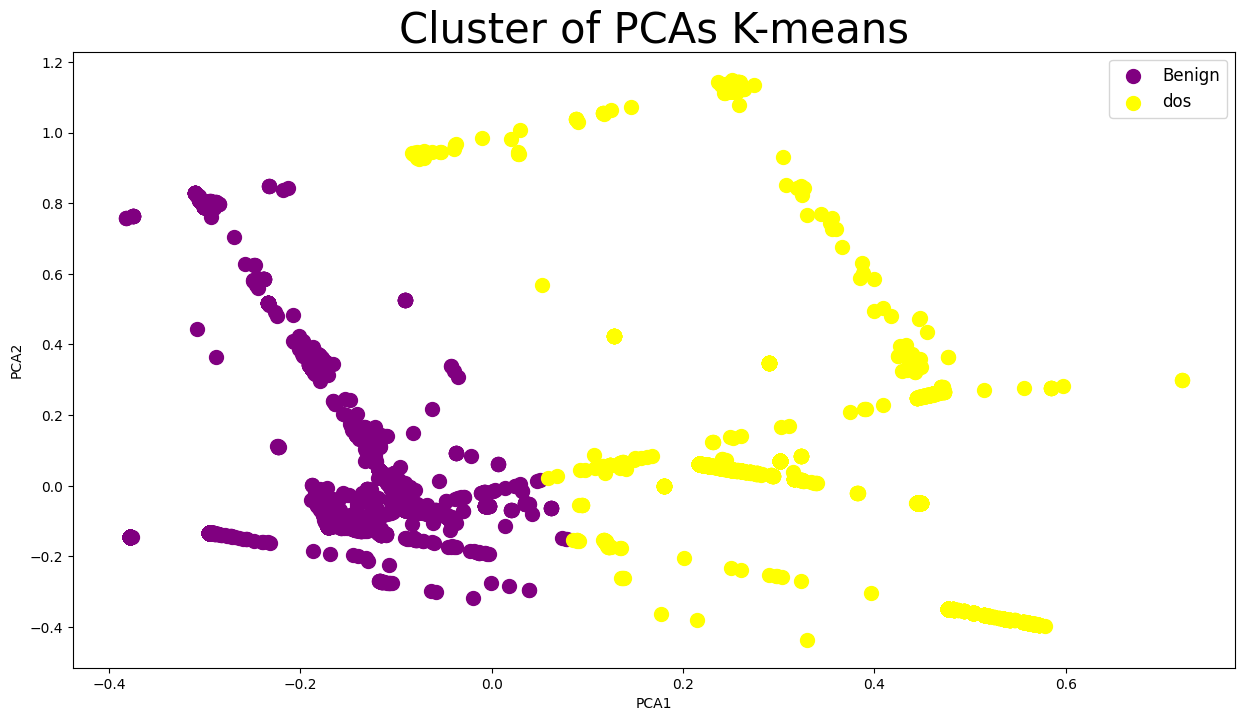

In [16]:
#Plot dei risultati

plt.figure(figsize=(15,8))
plt.title('Cluster of PCAs K-means', fontsize = 30)

plt.scatter(pca_x[y_pred == 0, 0], pca_x[y_pred == 0, 1], s = 100, c = 'purple', label = "Benign")
plt.scatter(pca_x[y_pred == 1, 0], pca_x[y_pred == 1, 1], s = 100, c = 'yellow', label = "dos")


plt.xlabel('PCA1')
plt.ylabel('PCA2')

# Add legend
plt.legend(fontsize='large')

title = "KMeans_PCA"
if not os.path.exists('image/'+nome_file+'/clustering_pca/'):
    os.makedirs('image/'+nome_file+'/clustering_pca/')
plt.savefig('image/'+nome_file+'/clustering_pca/'+ title +'.png')

plt.show()

In [17]:
accuracy_kmeans = str(accuracy_score(y_pred,bal_y))
precision_kmeans = str(precision_score(y_pred,bal_y))
recall_kmeans = str(recall_score(y_pred,bal_y))

# accuratezza kmeans
print("accuratezza " + accuracy_kmeans)
# precision kmeans
print("precision " + precision_kmeans)
# recall kemans
print("recall " + recall_kmeans)


metriche = pd.DataFrame({
    'metriche': ["accuracy","precision","recall"],
    'valori': [accuracy_kmeans,precision_kmeans,recall_kmeans]
})

if not os.path.exists('metriche/'+nome_file +'/clustering_pca/'):
    os.makedirs('metriche/'+nome_file +'/clustering_pca/')

metriche.to_csv('metriche/'+nome_file +'/clustering_pca'+'/metriche_kmeans_pca.csv',index=False)

accuratezza 0.8354640059243091
precision 0.7079549440698445
recall 0.9502982107355865


In [18]:
#clustering gerarchico

hc = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(pca_x)

# Associazione del cluster i-esimo con la classe i-esima
cluster_class_mapping = {}
for i in range(n_clusters):
    cluster_samples = pca_x[y_hc == i]
    cluster_classes = bal_y[y_hc == i]
    unique_classes, class_counts = np.unique(cluster_classes, return_counts=True)
    dominant_class = unique_classes[np.argmax(class_counts)]
    cluster_class_mapping[i] = dominant_class

/home/spalazzi/anaconda3/envs/cyber/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [19]:
difference = pd.DataFrame(data=[],columns=['num_cluster','num_class'])

# Stampiamo l'associazione del cluster con la classe
for i in range(n_clusters):
    if(i != cluster_class_mapping[i]):
        new_row = pd.Series({'num_cluster': i, 'num_class': cluster_class_mapping[i]})
        difference = pd.concat([difference,new_row.to_frame().T],ignore_index=True)

In [20]:
# se il numero del cluster e la classe non coincidono, andiamo ad effettuare uno switch

indici = []

for a in difference['num_cluster']:
    indici.append([
    index for index in range(len(y_hc))
    if y_hc[index] == a
])

for ind,true_value in zip(indici,difference['num_class']):
    for a in ind:
        y_hc[a] = true_value

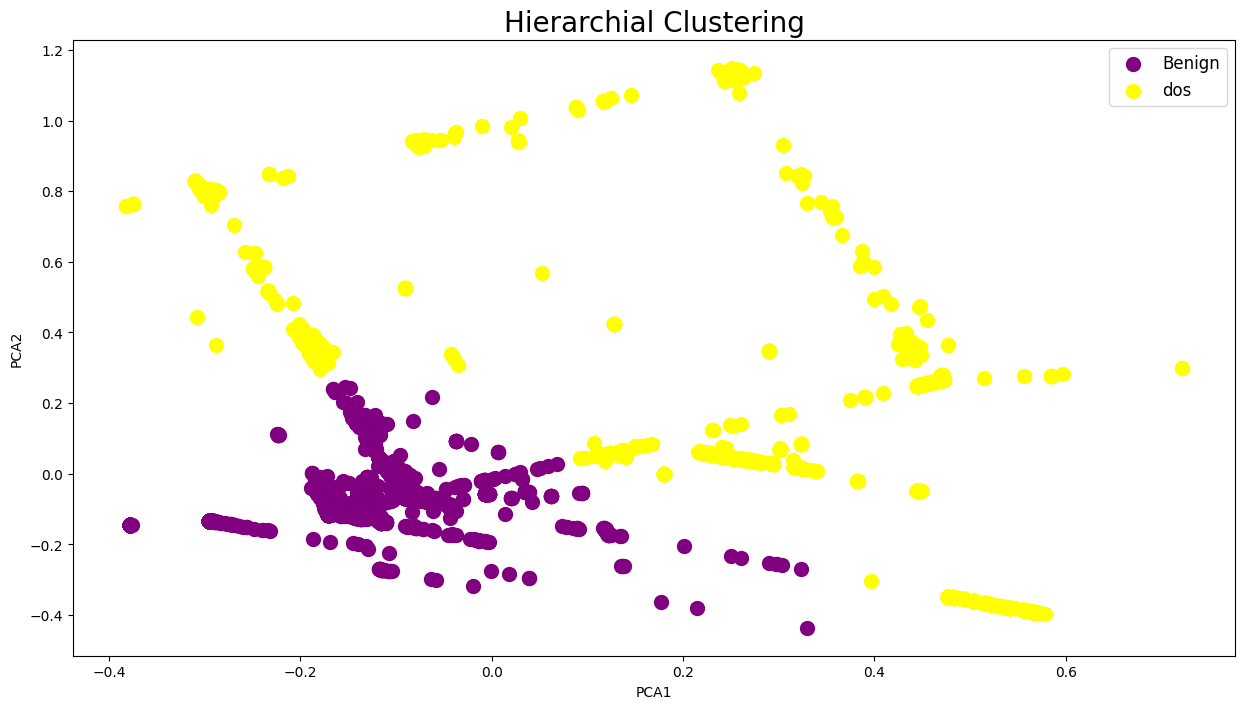

In [21]:
plt.figure(figsize=(15,8))
plt.scatter(pca_x[y_hc == 0, 0], pca_x[y_hc == 0, 1], s = 100, c = 'purple', label = "Benign")
plt.scatter(pca_x[y_hc == 1, 0], pca_x[y_hc == 1, 1], s = 100, c = 'yellow', label = "dos")

plt.title('Hierarchial Clustering', fontsize = 20)
plt.xlabel('PCA1')
plt.ylabel('PCA2')

# Add legend
plt.legend(fontsize='large')

title = ("Clust_gerarchico_PCA")
if not os.path.exists('image/'+nome_file+'/clustering_pca/'):
    os.makedirs('image/'+nome_file+'/clustering_pca/')
plt.savefig('image/'+nome_file+'/clustering_pca/'+ title +'.png')

plt.show()

In [22]:
accuracy_gerarchico = str(accuracy_score(y_hc,bal_y))
precision_gerarchico = str(precision_score(y_hc,bal_y))
recall_gerarchico = str(recall_score(y_hc,bal_y))

# accuratezza gerarchico
print("accuratezza" + accuracy_gerarchico)
# precision gerarchico
print("precision" + precision_gerarchico)
# recall gerarchico
print("recall" + recall_gerarchico)

metriche = pd.DataFrame({
    'metriche': ["accuracy","precision","recall"],
    'valori': [accuracy_gerarchico,precision_gerarchico,recall_gerarchico]
})

if not os.path.exists('metriche/'+nome_file +'/clustering_pca/'):
    os.makedirs('metriche/'+nome_file +'/clustering_pca/')

metriche.to_csv('metriche/'+nome_file +'/clustering_pca'+'/metriche_gerarchico_PCA.csv',index=False)

accuratezza0.7845422301905912
precision0.7079549440698445
recall0.8360104938555714


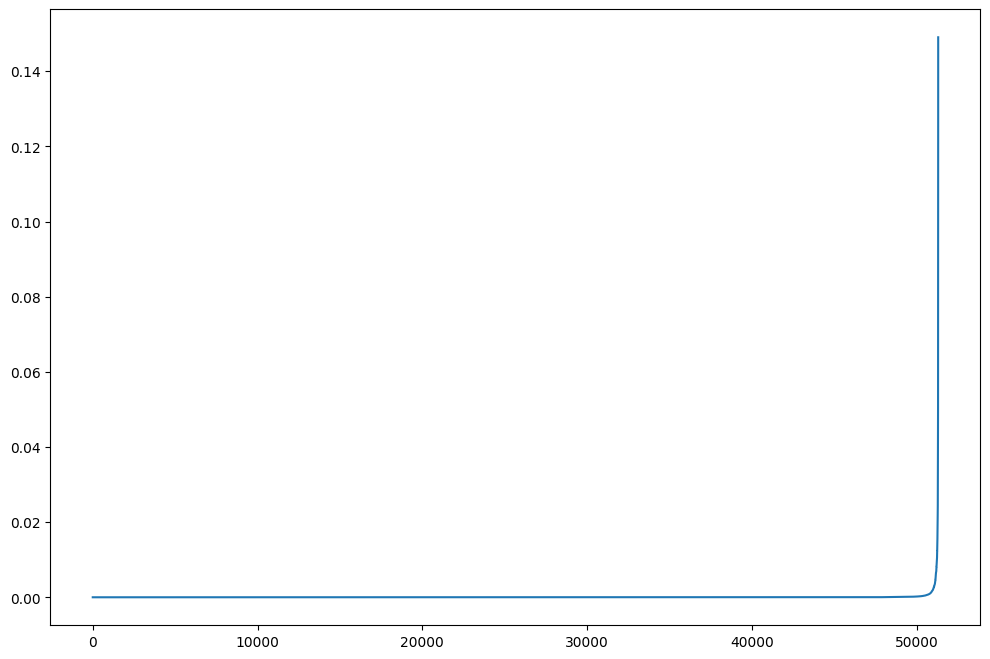

In [23]:
#individuazione eps

from sklearn.neighbors import NearestNeighbors
import numpy as np
import random

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(pca_x)
distances, indices = nbrs.kneighbors(pca_x)

distances = np.sort(distances, axis=0)
plt.figure(figsize=(12,8))
plt.plot(distances[:,1])

In [24]:
#applicazione DBSCAN

from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.01, min_samples=6).fit(pca_x)
y_scan = db.labels_
y_scan

array([ 0,  0,  0, ...,  1, 11, 14])

In [25]:
# Associazione del cluster i-esimo con la classe i-esima
cluster_class_mapping = {}
for i in range(n_clusters):
    cluster_samples = pca_x[y_scan == i]
    cluster_classes = bal_y[y_scan == i]
    unique_classes, class_counts = np.unique(cluster_classes, return_counts=True)
    dominant_class = unique_classes[np.argmax(class_counts)]
    cluster_class_mapping[i] = dominant_class

In [26]:
difference = pd.DataFrame(data=[],columns=['num_cluster','num_class'])

# Stampiamo l'associazione del cluster con la classe
for i in range(n_clusters):
    if(i != cluster_class_mapping[i]):
        new_row = pd.Series({'num_cluster': i, 'num_class': cluster_class_mapping[i]})
        difference = pd.concat([difference,new_row.to_frame().T],ignore_index=True)

In [27]:
# se il numero del cluster e la classe non coincidono, andiamo ad effettuare uno switch

indici = []

for a in difference['num_cluster']:
    indici.append([
    index for index in range(len(y_scan))
    if y_scan[index] == a
])

for ind,true_value in zip(indici,difference['num_class']):
    for a in ind:
        y_scan[a] = true_value

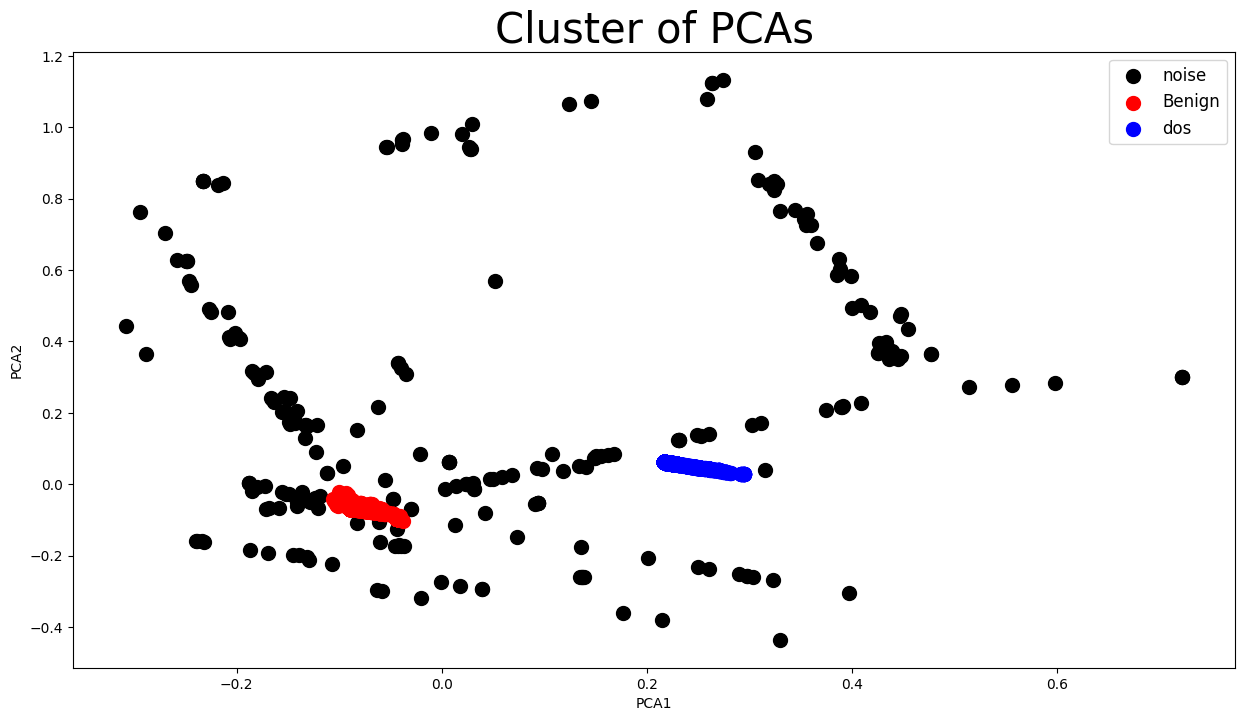

In [28]:
plt.figure(figsize=(15,8))
plt.title('Cluster of PCAs', fontsize = 30)

plt.scatter(pca_x[y_scan == -1, 0], pca_x[y_scan == -1, 1], s = 100, c = 'black', label = "noise")
plt.scatter(pca_x[y_scan == 0, 0], pca_x[y_scan == 0, 1], s = 100, c = 'red', label = "Benign")
plt.scatter(pca_x[y_scan == 1, 0], pca_x[y_scan == 1, 1], s = 100, c = 'blue', label = "dos")

plt.xlabel('PCA1')
plt.ylabel('PCA2')

# Add legend
plt.legend(fontsize='large')

title = ("DB_Scan_PCA")
feature_name = title.replace('/','_')
if not os.path.exists('image/'+nome_file+'/clustering_pca/'):
    os.makedirs('image/'+nome_file+'/clustering_pca/')
plt.savefig('image/'+nome_file+'/clustering_pca/'+ title +'.png')

plt.show()

In [29]:
accuracy_dbscan = str(accuracy_score(y_scan,bal_y))
precision_dbscan = str(precision_score(y_scan,bal_y,average='weighted'))
recall_dbscan = str(recall_score(y_scan,bal_y,average='weighted'))

# accuratezza dbscan
print("accuratezza" + accuracy_dbscan)
# precision dbscan
print("precision" + precision_dbscan)
# recall dbscan
print("recall" + recall_dbscan)

metriche = pd.DataFrame({
    'metriche': ["accuracy","precision","recall"],
    'valori': [accuracy_dbscan,precision_dbscan,recall_dbscan]
})

if not os.path.exists('metriche/'+nome_file +'/clustering_pca/'):
    os.makedirs('metriche/'+nome_file +'/clustering_pca/')

metriche.to_csv('metriche/'+nome_file +'/clustering_pca'+'/metriche_dbscan_PCA.csv',index=False)

accuratezza0.4108235569240363
precision0.2250662763044759
recall0.4108235569240363


/home/spalazzi/anaconda3/envs/cyber/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
